## GSE22058-GPL10457 part 3 (human hepatocellular carcinoma, pre-processing of raw sample data)
The script allows to pre-process **GSE22058-GPL10457** raw sample data sets acquired from GEO data base. 
<br>
<br>
**GSE22058-GPL10457** data set consists of 194 samples:

* 96 positive samples,
* and 96 negative samples (adjacent to the positive).
<br>

**For detailed information please refer to:** https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE22058
<br>

**Related publication:**
<br>
Burchard J, Zhang C, Liu AM, Poon RT et al. microRNA-122 as a regulator of mitochondrial metabolic gene network in hepatocellular carcinoma. Mol Syst Biol 2010 Aug 24;6:402. (DOI: 10.1038/msb.2010.58)

**Before you start:**
* **Download** and unzip series matrix first: 
https://ftp.ncbi.nlm.nih.gov/geo/series/GSE10nnn/GSE10694/matrix/GSE10694_series_matrix.txt.gz
* **Required libraries**: *GEOquery*, *repr*

The code is written by @MelaniaNowicka, Free University of Berlin (contact: melania.nowicka@gmail.com).

**Import necessary libraries**

In [1]:
# read the necessary libraries
library("GEOquery")
library("ggplot2")
library("limma")

# read utility functions
source("utility-functions.R")
source("split-real-data.R")

Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min

Welcome to Bioconductor

    Vignettes contain introductory material; view with


**Pre-process data prepared in Part 2**

**Quantile normalize data sets separately and keep the same data division as for Part 1**

Note, data division into train-test cross-validation folds was performed in further pre-processing, but we use the same sample division in this step.

,1,2,3,4,5,6,7,8,9,10,...,183,184,185,186,187,188,189,190,191,192
hsa.let.7a,21506.16,20106.201,24658.95,21967.01,19753.371,27297.63,18434.268,23414.14,11774.381,42959.11,...,8183.538,15580.505,14157.417,18841.070,20881.701,26895.889,8496.543,18639.232,31459.78,80062.94
hsa.let.7b,18094.69,16587.941,13449.49,19183.16,17384.744,23048.41,11391.020,25682.61,14737.618,36787.49,...,5422.161,13475.854,5198.236,17873.281,7491.099,11503.568,7707.242,11561.776,22598.09,24571.37
hsa.let.7c,10562.25,11387.468,10384.45,10819.34,9233.444,11530.68,9937.753,11825.24,5830.999,16558.32,...,2118.450,6733.054,2633.848,6231.408,6268.630,8511.818,3600.634,7658.510,15354.88,11818.38
hsa.let.7d,14688.51,11065.344,13943.13,11529.33,10799.913,15478.70,12642.770,11219.10,6157.327,27663.75,...,5620.048,9789.960,7760.472,15660.670,16581.340,16223.674,6141.712,10345.869,19009.94,52977.48
hsa.let.7e,12008.36,8529.754,11375.10,13263.95,11372.279,15011.13,8541.295,12219.93,5601.679,18941.07,...,3194.612,5704.506,8344.347,16082.149,16210.049,8369.788,5393.667,7973.273,15762.41,22960.35
hsa.let.7f,24428.48,16071.626,26437.16,27499.13,12446.384,16510.43,20891.340,17656.56,13249.135,26380.15,...,9245.779,11820.498,18438.684,27607.207,55022.777,28342.646,15515.076,26351.357,47532.80,79616.95


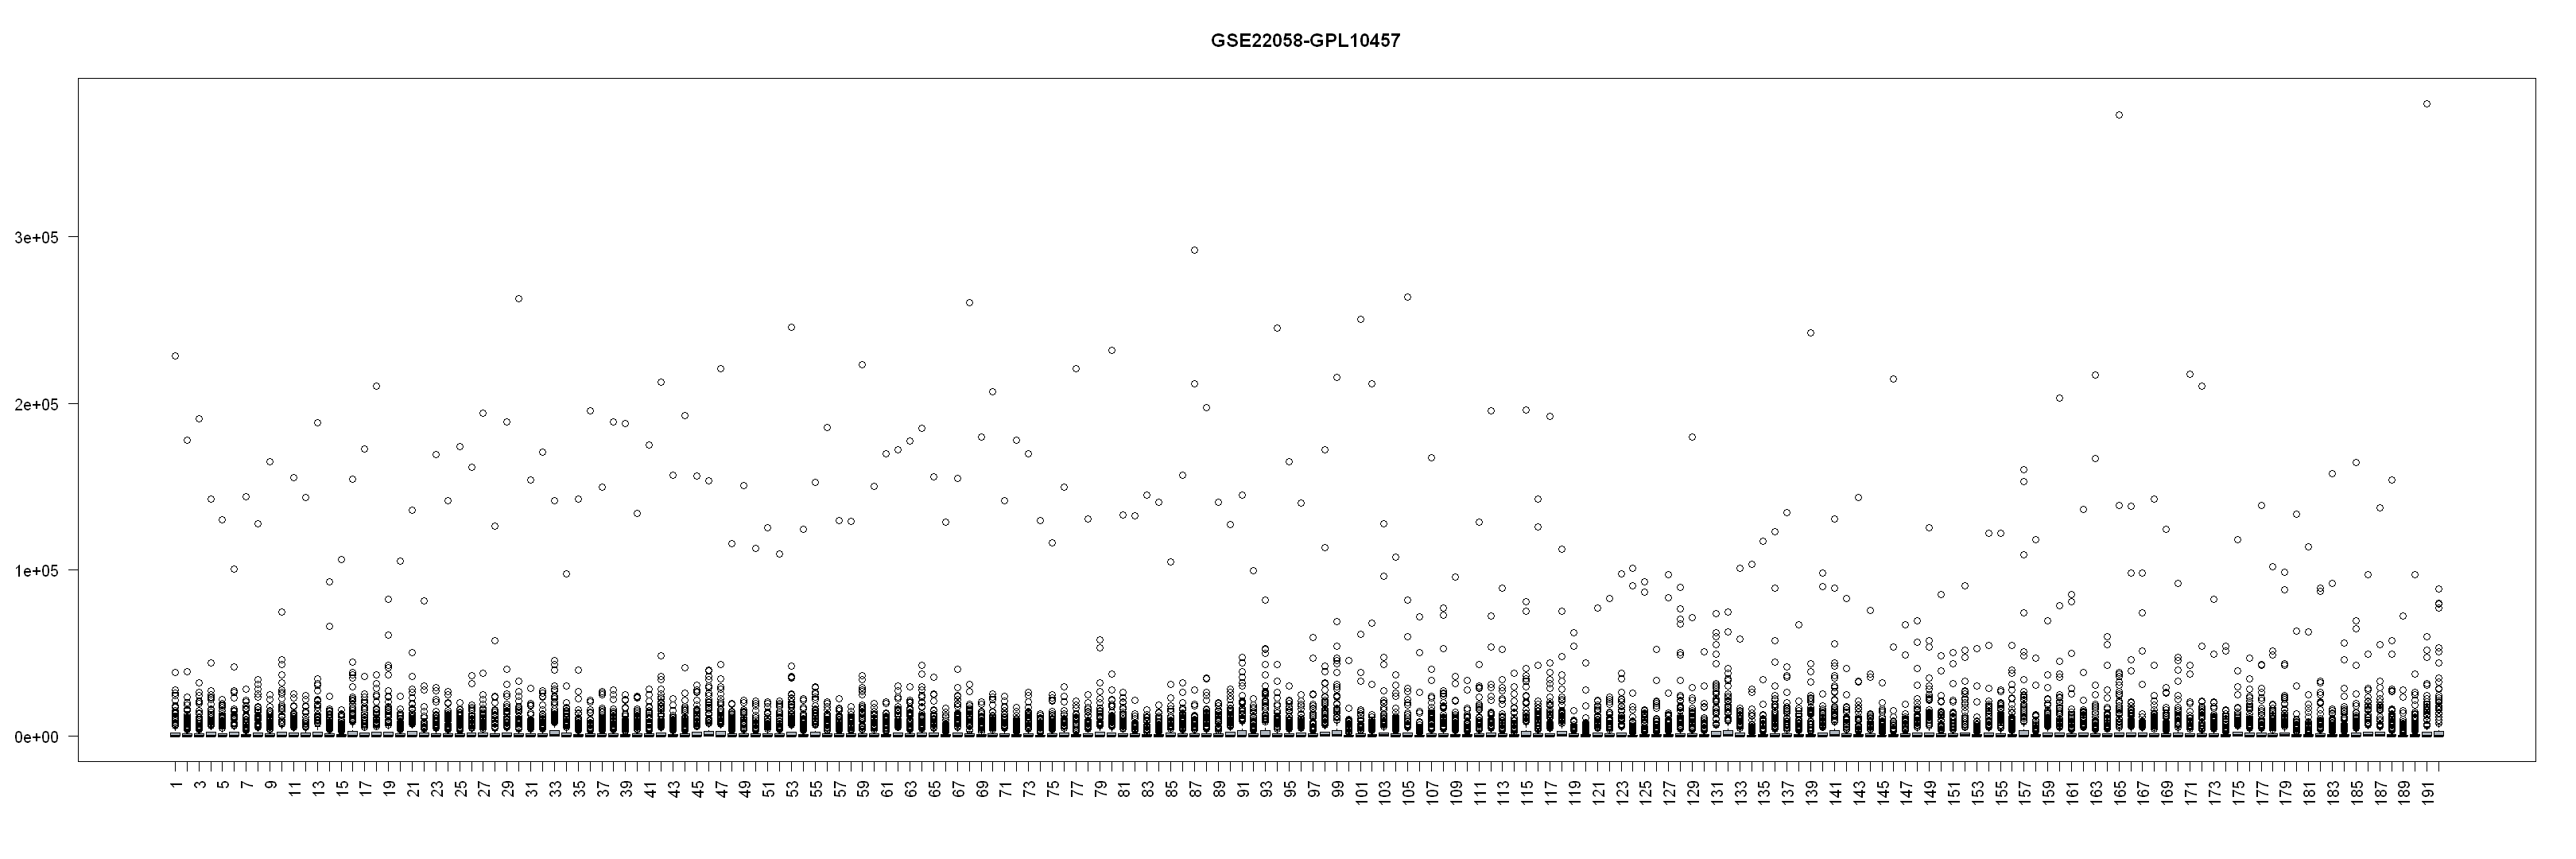

In [2]:
#non.norm <- read.csv2("GSE22058_non_norm_formatted.csv", dec=".")

# read sample info and non normalized data
sample.info <- read.csv2("GSE22058/joint-norm/GSE22058_sample_info.csv")
data.set <- read.csv2("reproducibility/sep-norm/GSE22058/GSE22058_non_norm_formatted.csv", dec=".")

# transpose and cut ids and annotation
count.matrix <- as.data.frame(t(data.set[,3:212]))
colnames(count.matrix) <- as.character(sample.info$new_ids)
annotation <- sample.info$annotation
head(count.matrix)

# create plot of all non normalized samples
#jpeg(file="GSE22058_all.jpeg", width=1500, height=500)
options(repr.plot.width=27, repr.plot.height=9)
boxplot(count.matrix, col = "#AEB6BF", las = 2, main="GSE22058-GPL10457", ylab="")
#dev.off()

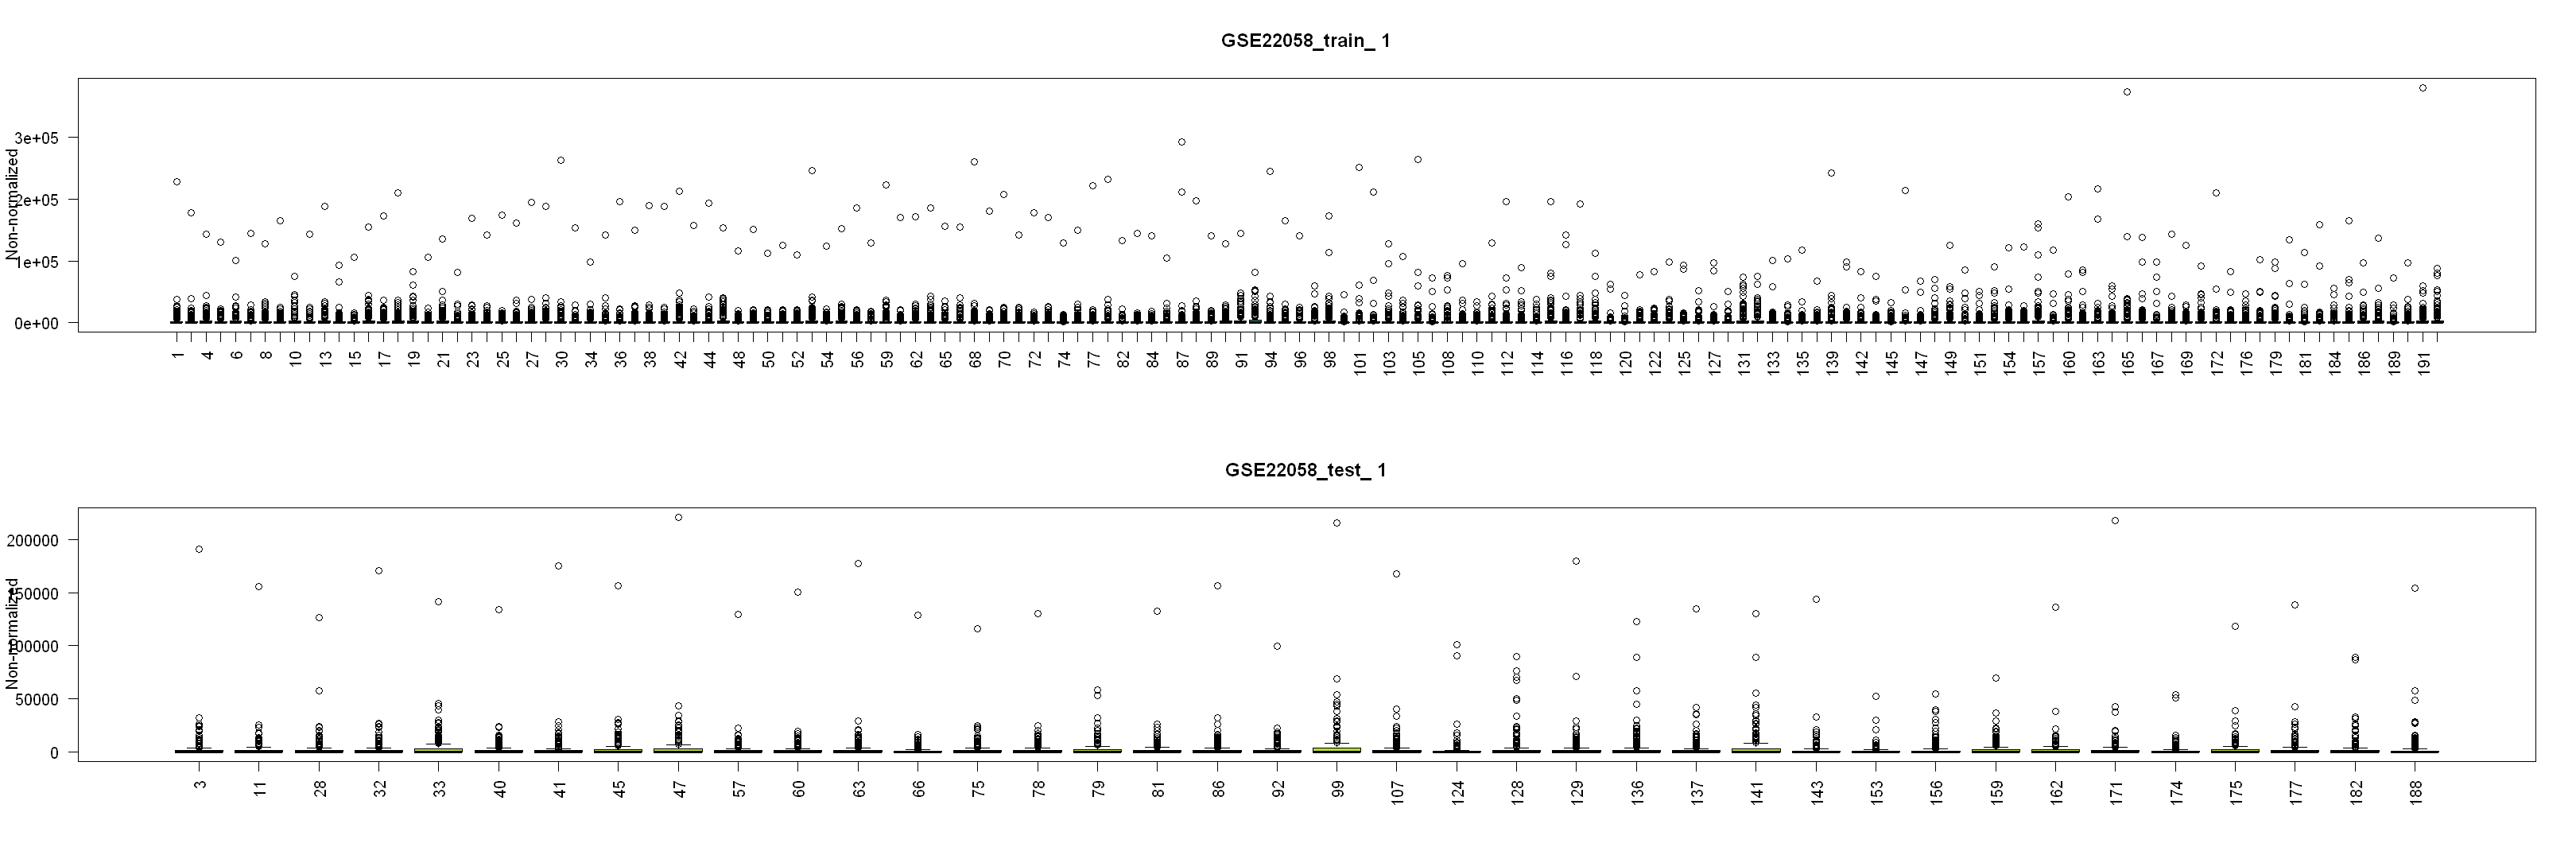

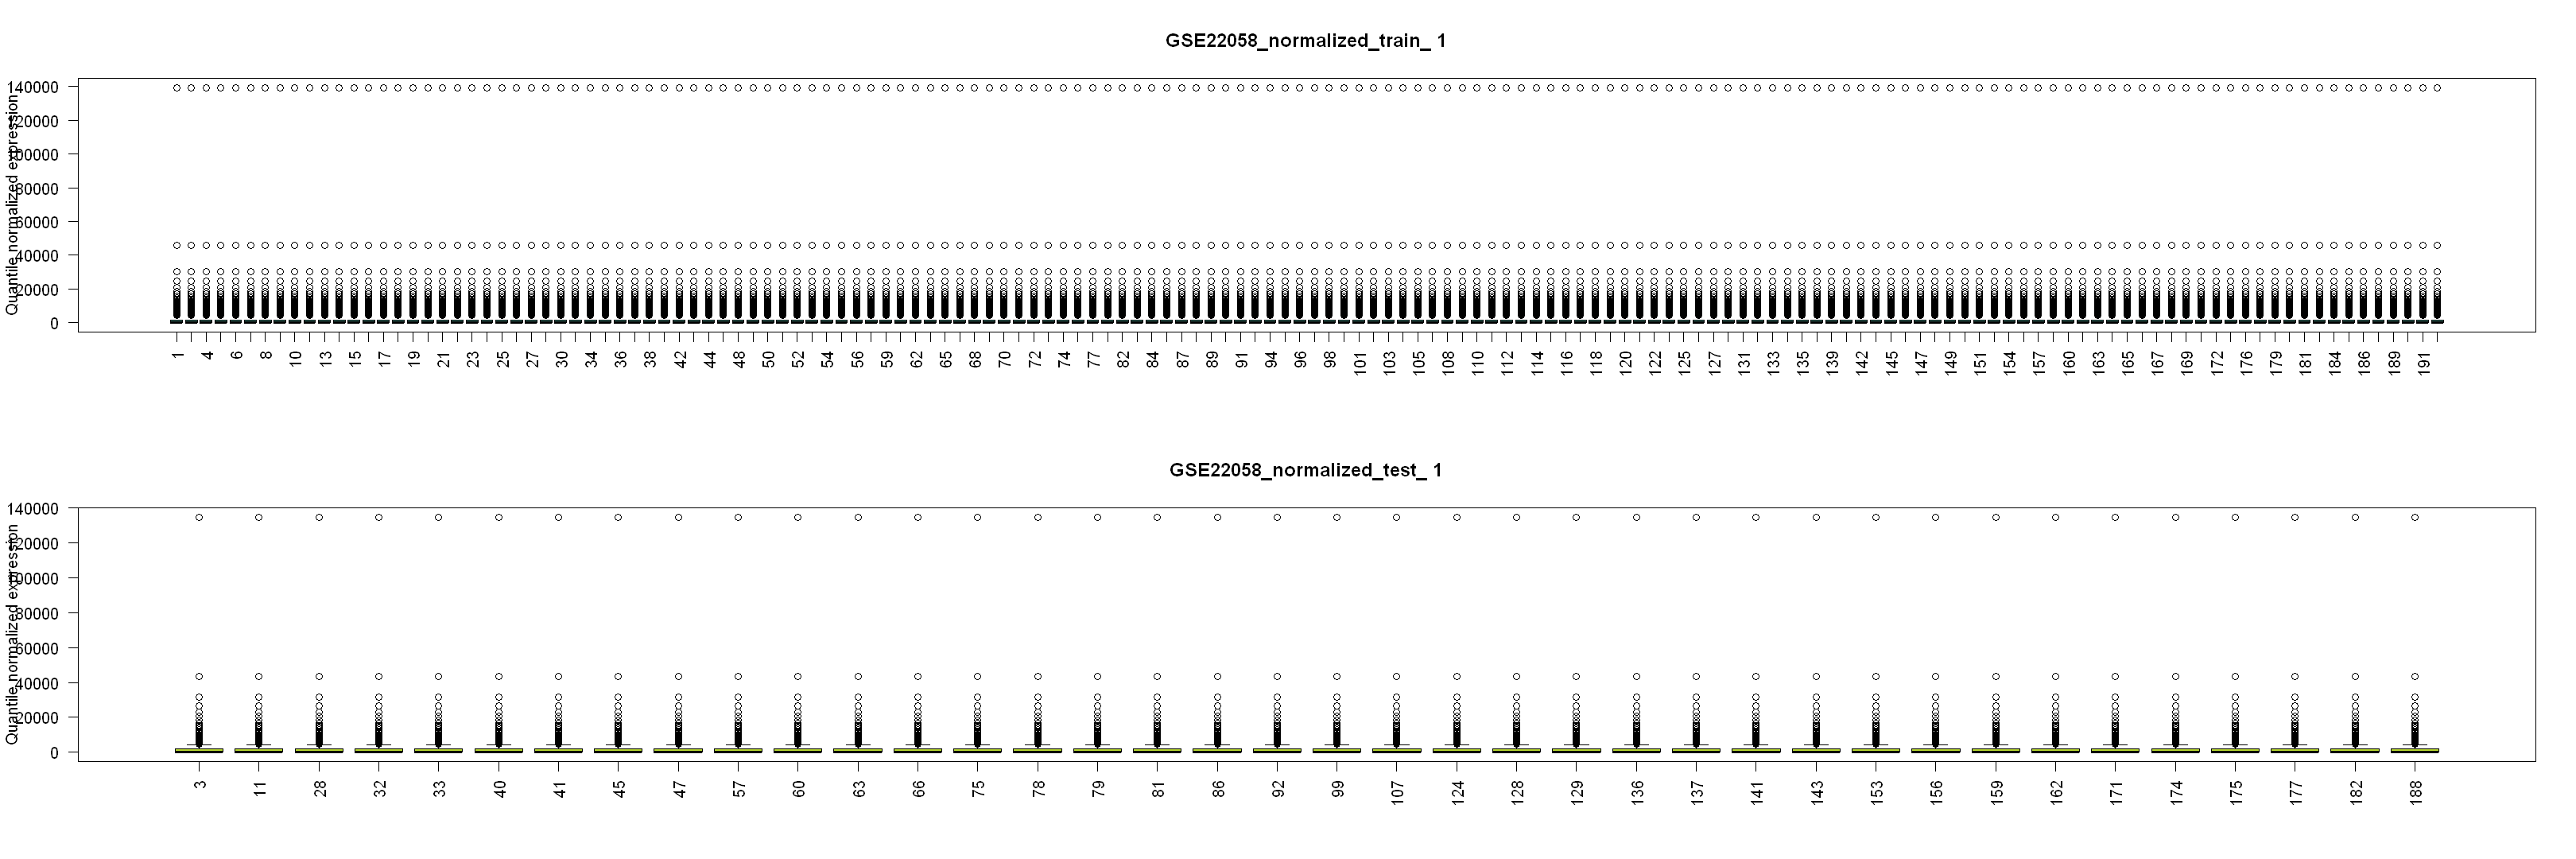

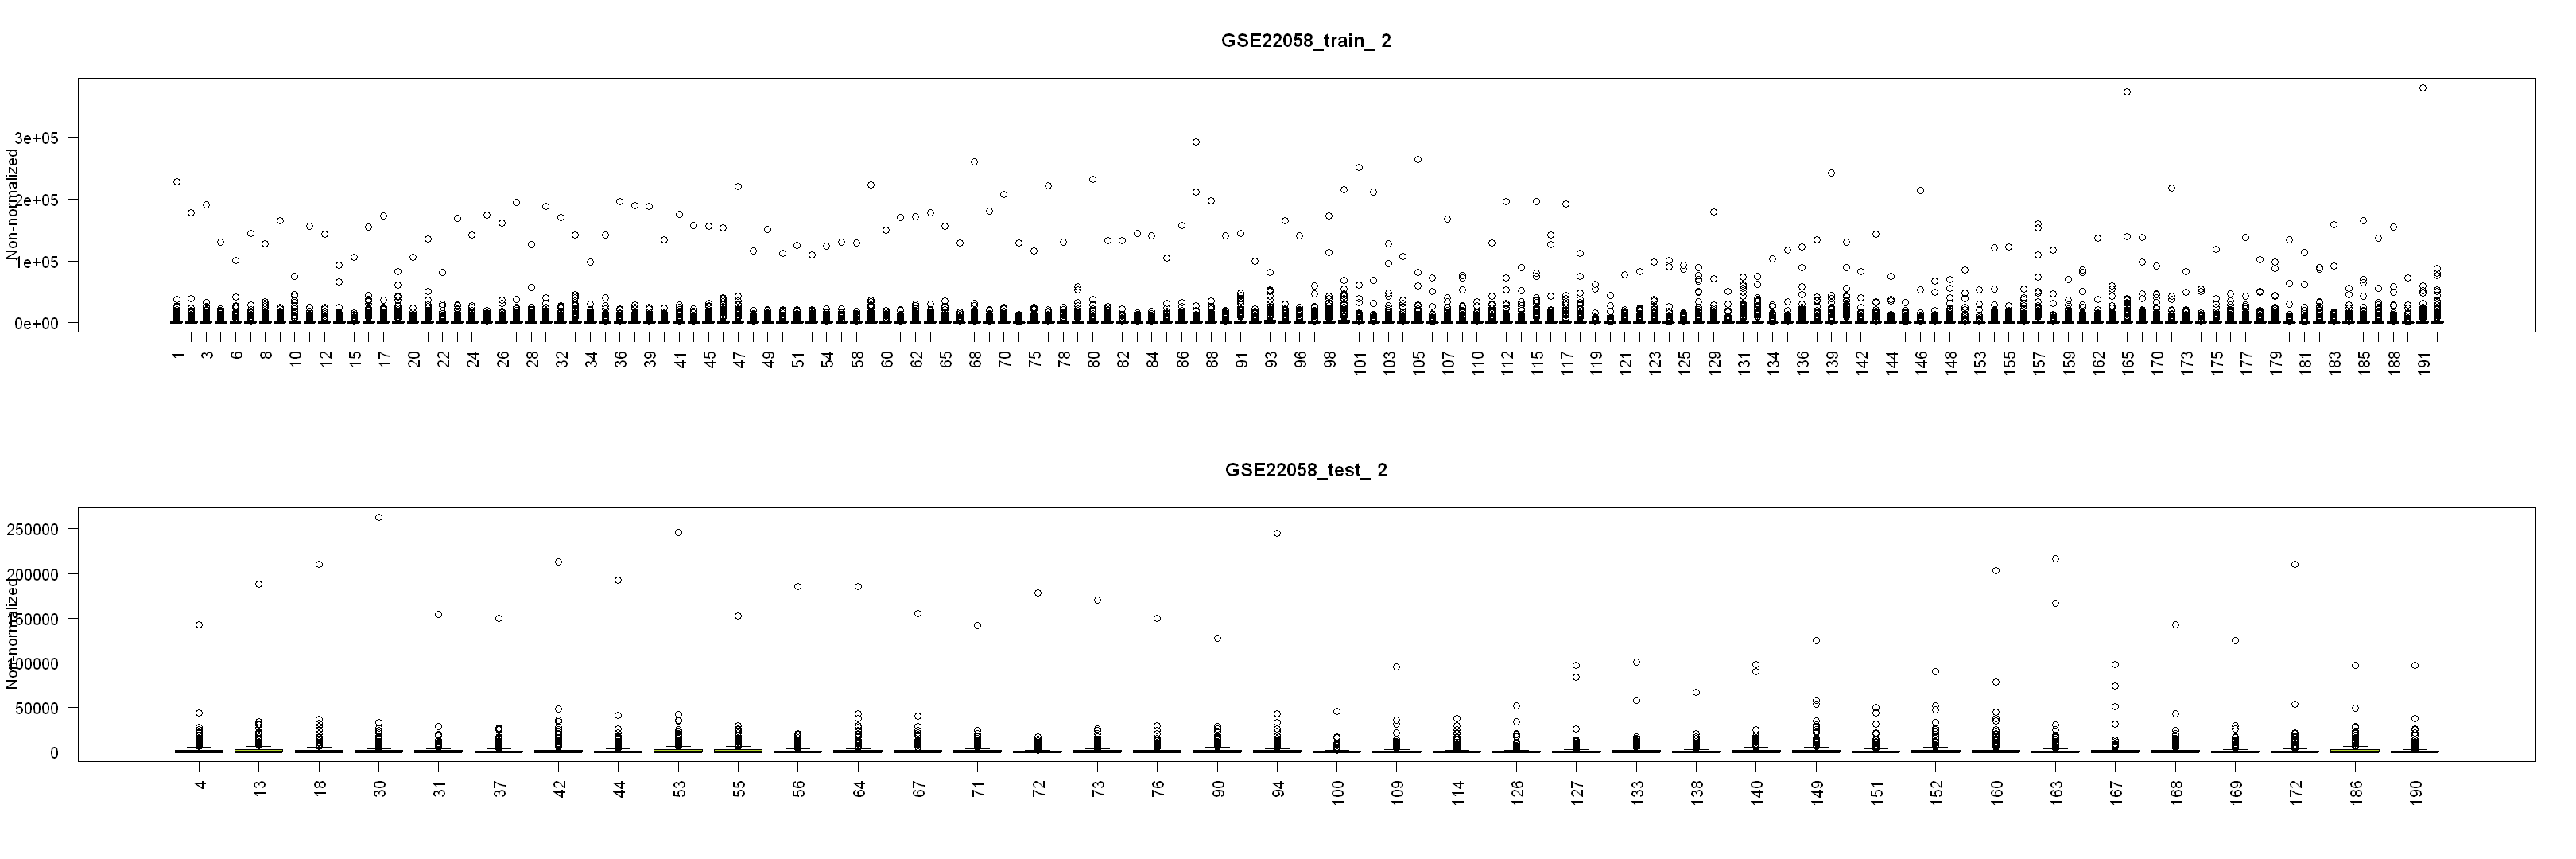

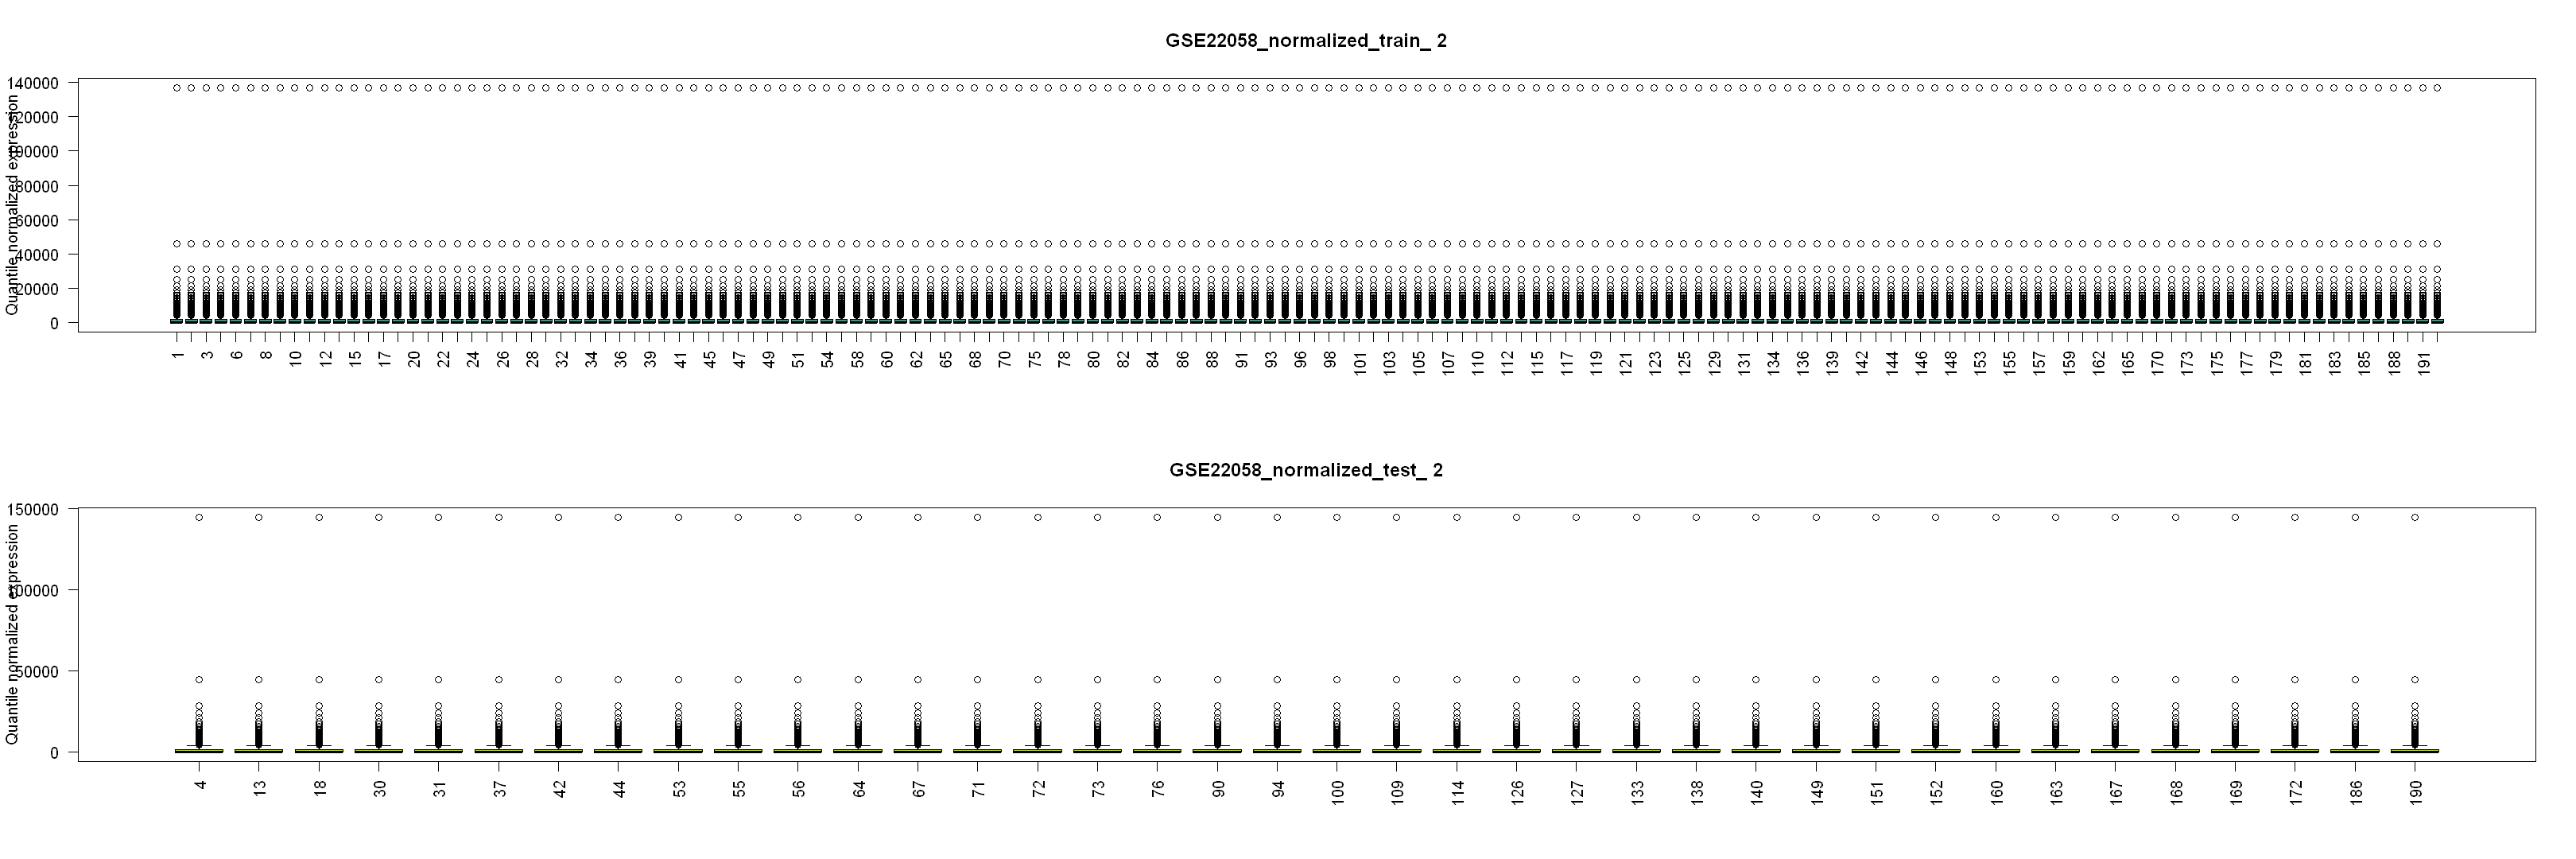

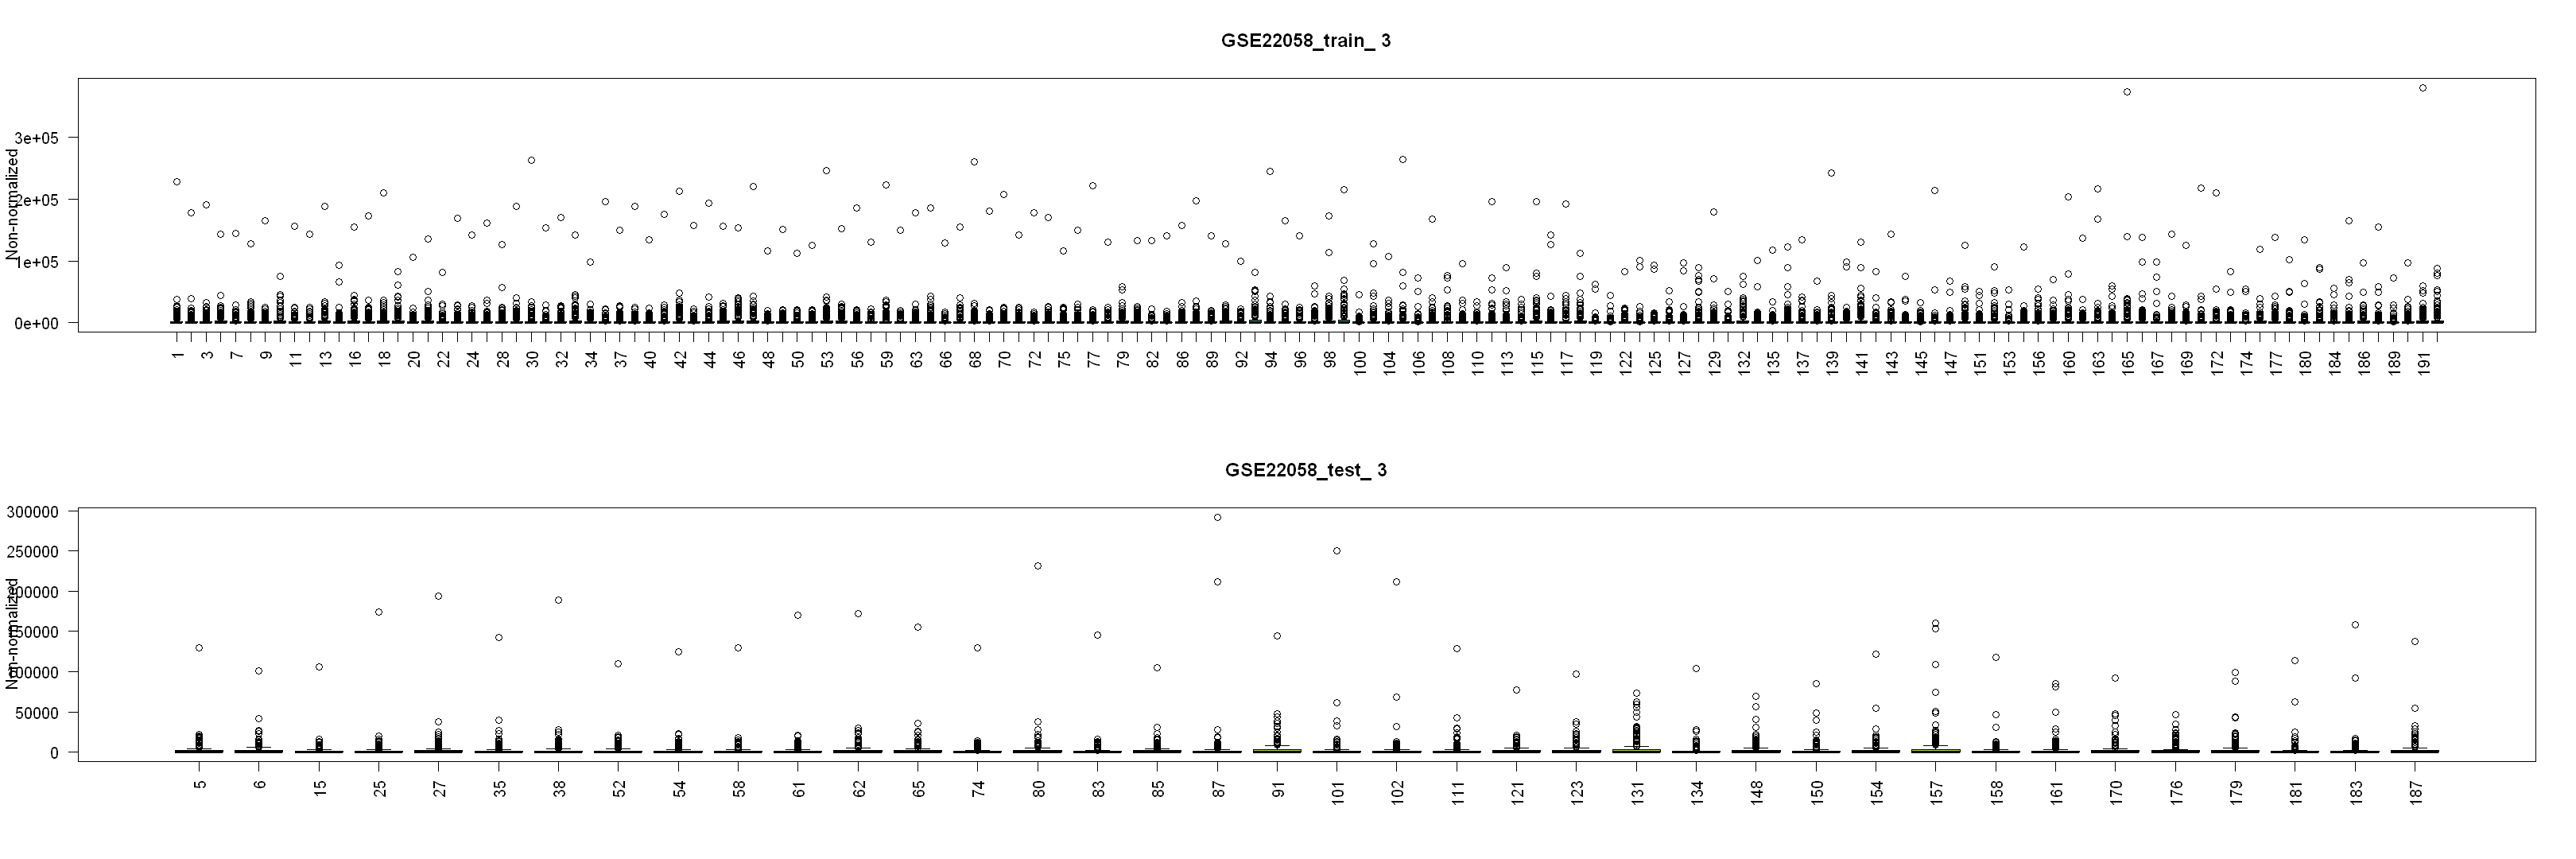

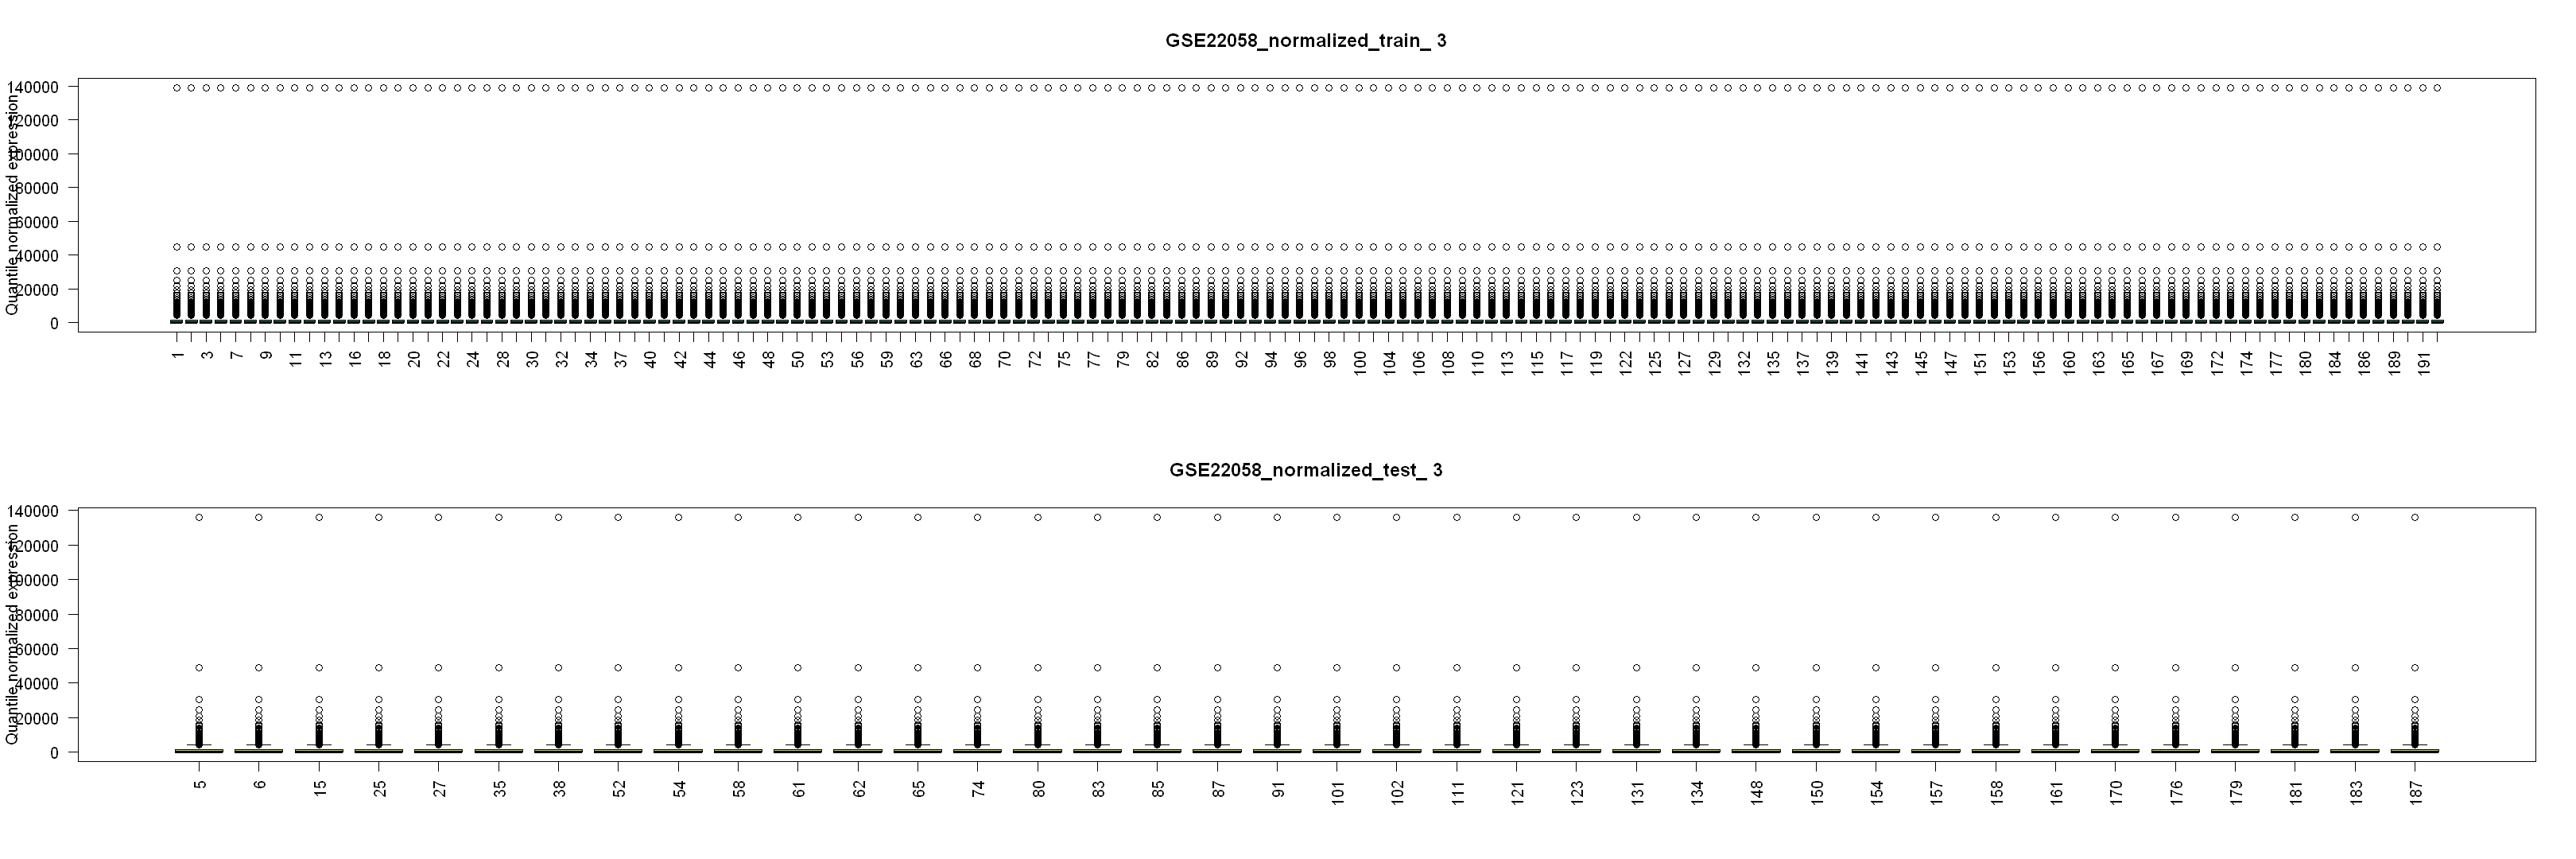

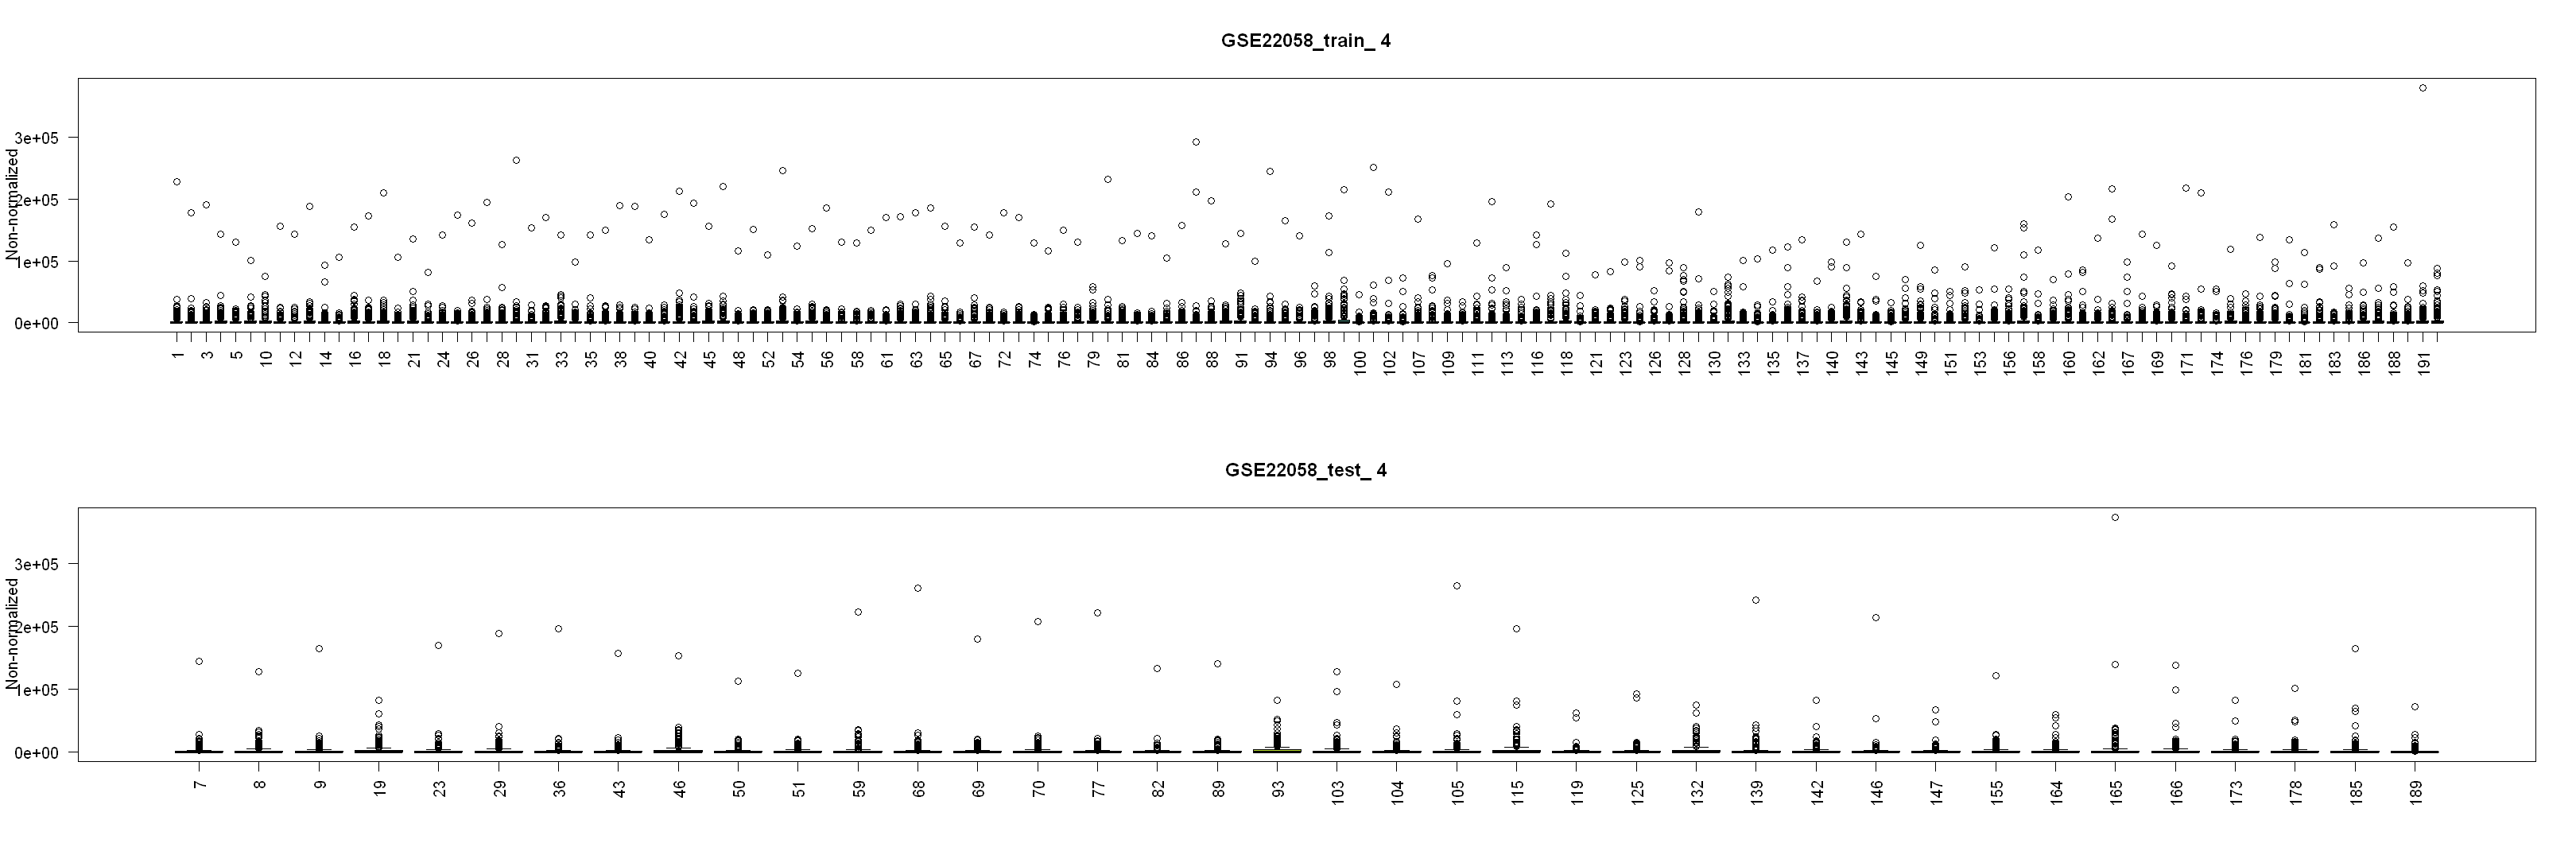

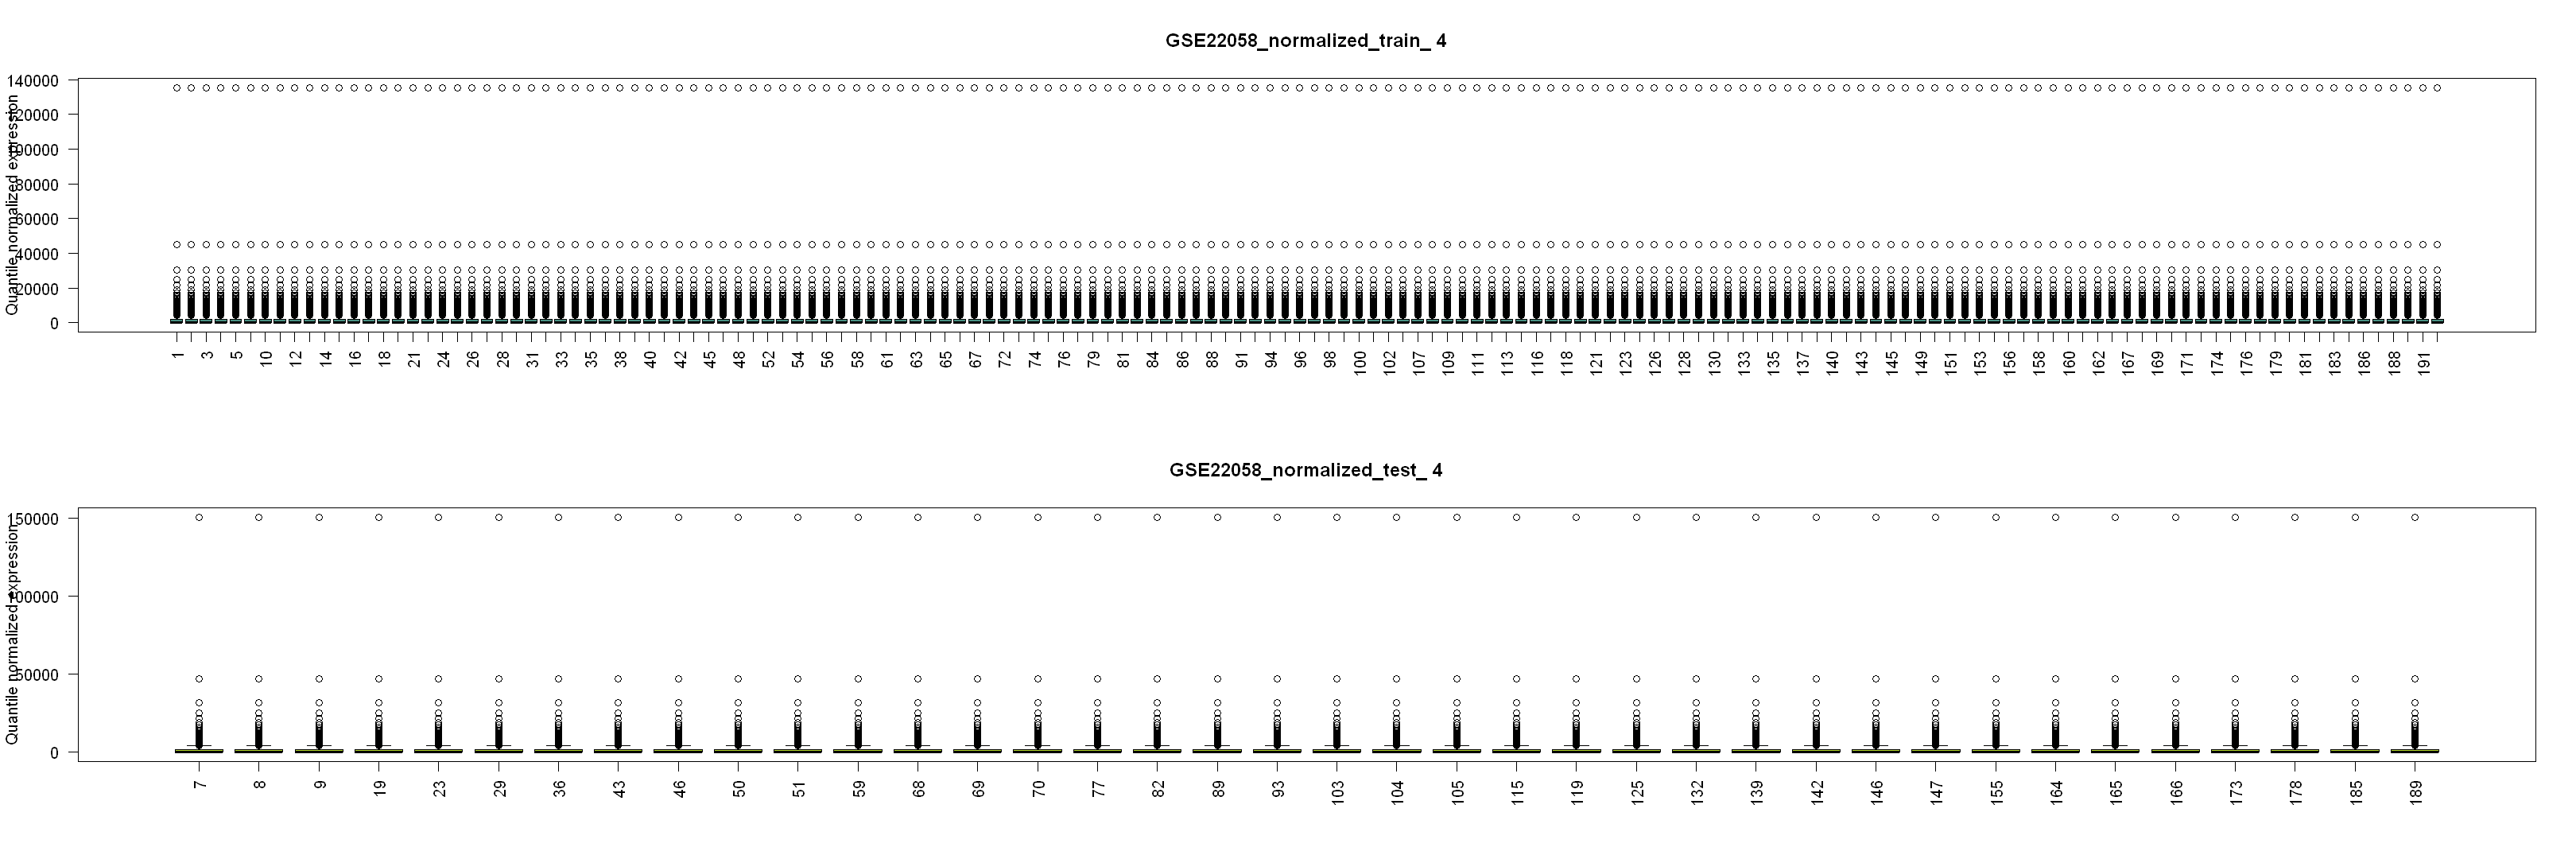

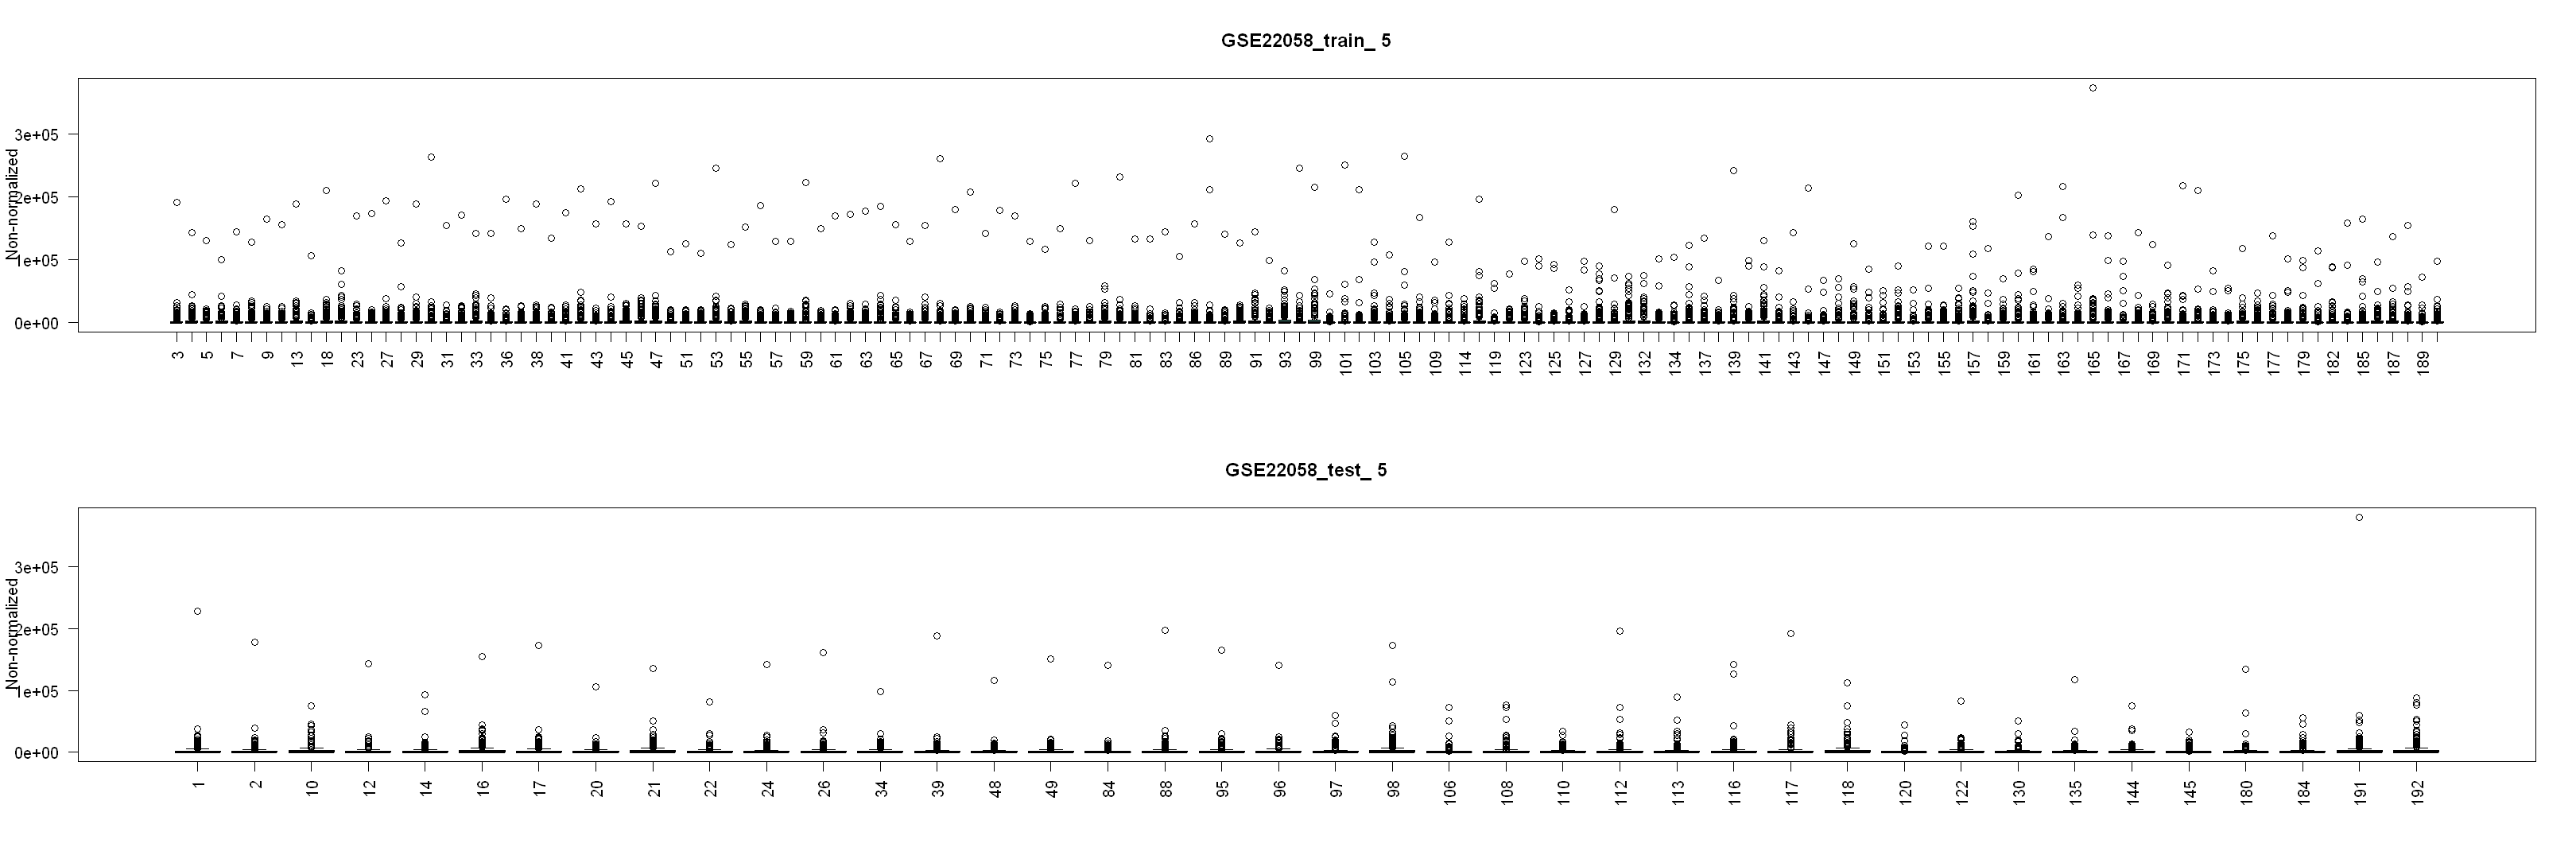

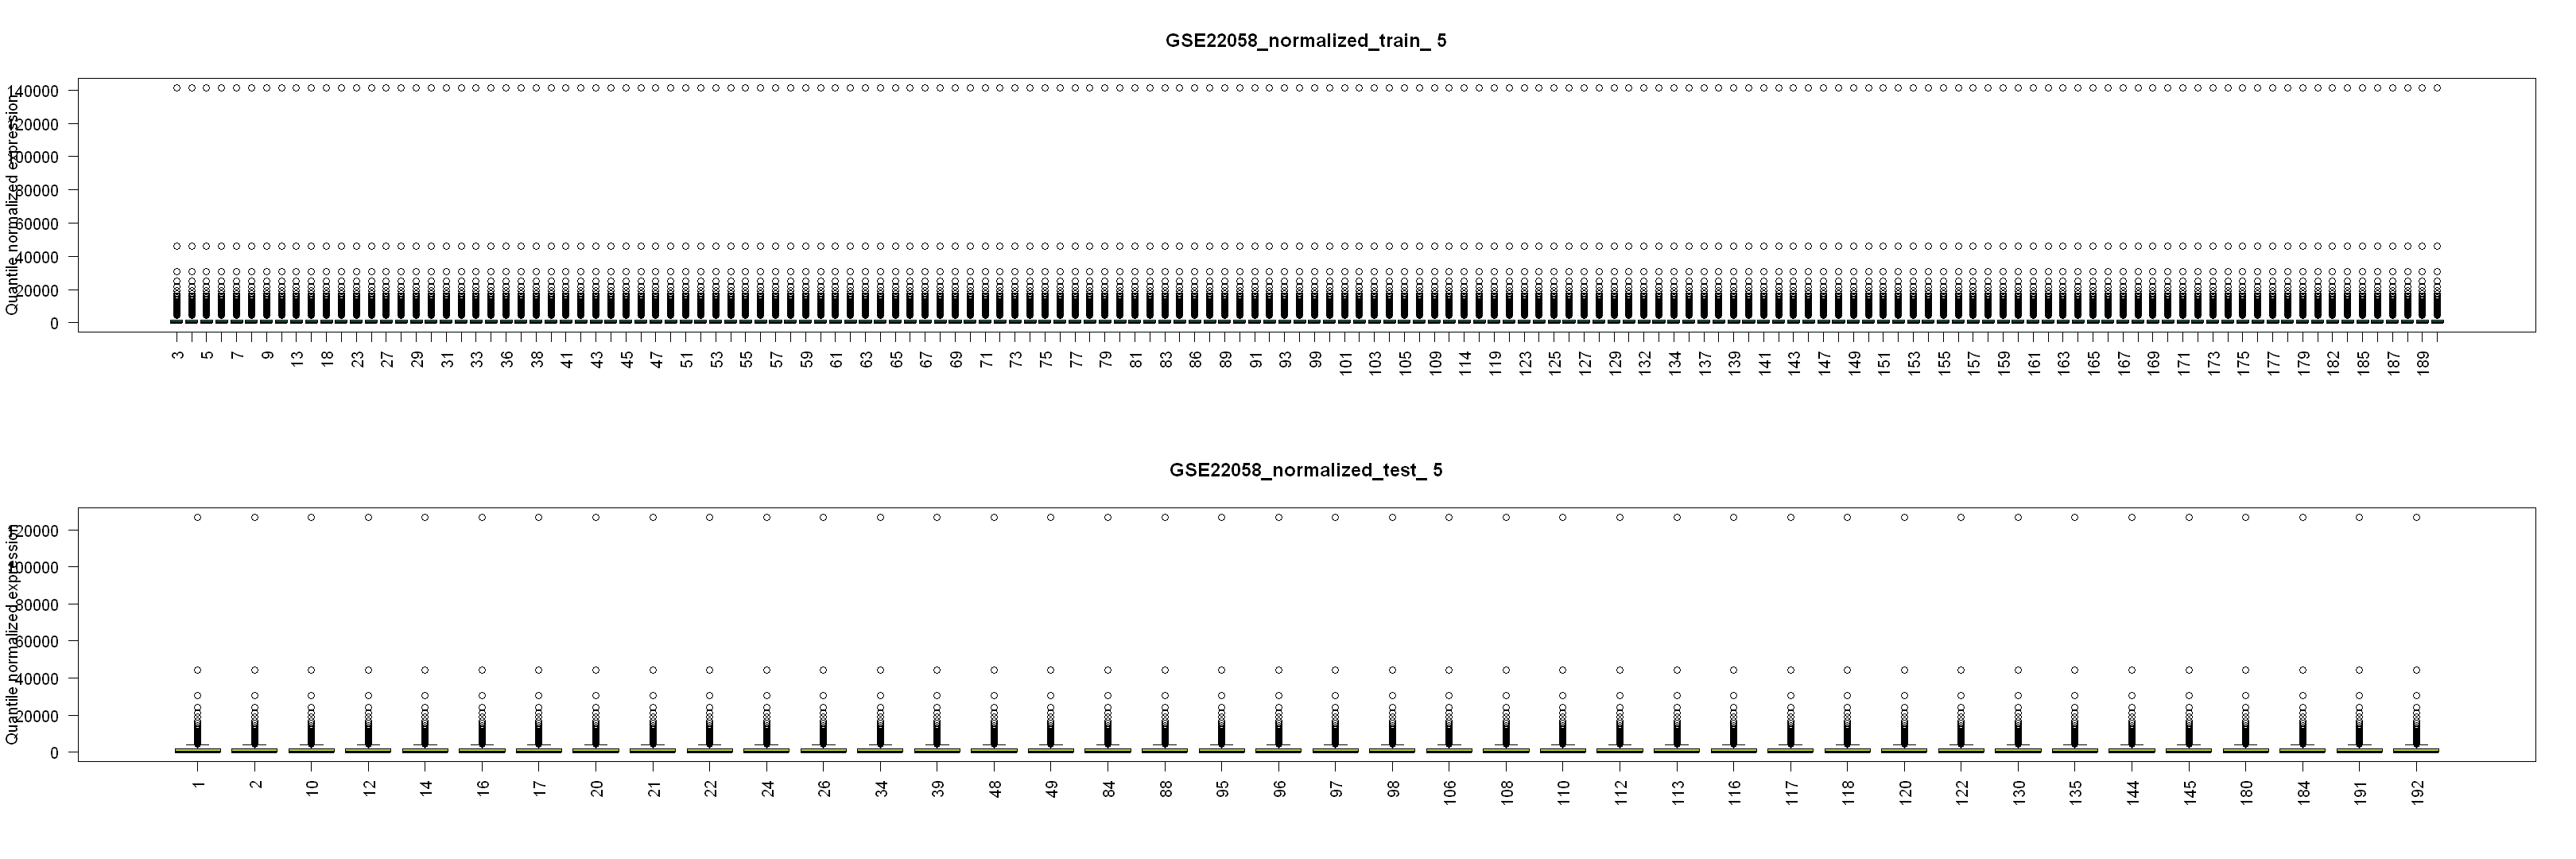

In [3]:
for (i in 1:5) {
  
  #get sample IDs for division
  train <- read.csv2(paste("GSE22058/joint-norm/GSE22058_cv_train_", i, ".csv", sep=""))
  train.samples <- train$ID
  test <- read.csv2(paste("GSE22058/joint-norm/GSE22058_cv_val_", i, ".csv", sep=""))
  test.samples <- test$ID
  
  # divide intro train and test data
  file.name <- "GSE22058_non-norm"
  
  # split data by sample
  count.matrix.split <- splitRealWorldData(name=file.name, 
                                        count.matrix=count.matrix, 
                                        annotation=annotation, 
                                        negative.samples=96, 
                                        positive.samples=96, 
                                        train.fraction=0.8, 
                                        by.sample=TRUE, 
                                        train.samples=train.samples, 
                                        test.samples=test.samples,
                                        save.to.file=FALSE)
  
  train.data.set <- count.matrix.split$train.data.set 
  train.annots <- as.numeric(count.matrix.split$train.annots[1,])
  test.data.set <- count.matrix.split$test.data.set
  test.annots <- as.numeric(count.matrix.split$test.annots[1,])
  
  file.name <- paste("reproducibility/sep-norm/GSE22058/GSE22058_non-norm_train_", i, ".csv", sep = "")
  
  save_matrix(file_name=file.name, train.annots, train.data.set)
  
  file.name <- paste("reproducibility/sep-norm/GSE22058/GSE22058_non-norm_test_", i, ".csv", sep = "")
  
  save_matrix(file_name=file.name, test.annots, test.data.set)
  
  #jpeg(file=paste("GSE22058_non-norm_", i, ".jpeg", sep=""), width=1500, height=500)
  options(repr.plot.width=27, repr.plot.height=9)
  par(mfrow=c(2,1))
  boxplot(train.data.set, col = "#217867d2", las = 2, main=paste("GSE22058_train_", i), ylab="Non-normalized")
  boxplot(test.data.set, col = "#aad400cd", las = 2, main=paste("GSE22058_test_", i), ylab="Non-normalized")
  #dev.off()
  
  train.data.set.norm <- normalizeQuantiles(train.data.set)
  test.data.set.norm <- normalizeQuantiles(test.data.set)
  
  file.name <- paste("reproducibility/sep-norm/GSE22058/GSE22058_sep-norm_train_", i, ".csv", sep = "")
  
  save_matrix(file_name=file.name, train.annots, train.data.set.norm)
  
  file.name <- paste("reproducibility/sep-norm/GSE22058/GSE22058_sep-norm_test_", i, ".csv", sep = "")
  
  save_matrix(file_name=file.name, test.annots, test.data.set.norm)
  
  #jpeg(file=paste("GSE22058_normalized_", i, ".jpeg", sep=""), width=1500, height=500)
  options(repr.plot.width=27, repr.plot.height=9)
  par(mfrow=c(2,1))
  boxplot(train.data.set.norm, col = "#217867d2", las = 2, main=paste("GSE22058_normalized_train_", i), ylab="Quantile normalized expression")
  boxplot(test.data.set.norm, col = "#aad400cd", las = 2, main=paste("GSE22058_normalized_test_", i), ylab="Quantile normalized expression")
  #dev.off()
  
}